In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg
import datetime as dt
import calendar as cal

In [3]:
@functools.lru_cache(maxsize = 16)
def fetch_quandl(my_securities, start_date, end_date):
    qdata = Quandl.get(list(my_securities), returns="pandas", trim_start=start_date, trim_end=end_date,authtoken = "wzAChXmyCmhw1inzoJQW")
    return qdata

data = fetch_quandl(("EOD/RYU","EOD/XLU"),"2013-12-02","2015-12-31")

In [5]:
def clean_quandl_data(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

data = clean_quandl_data(data)

In [8]:
data["RYU:Dollar_Volume"]=data["RYU:Adj_Close"] * data["RYU:Adj_Volume"]
Nt = data["RYU:Dollar_Volume"].rolling(window=15).median()
Qx = ((Nt/100)/data["RYU:Adj_Close"]).fillna(value = 0).astype(int)
Qy = ((Nt/100)/data["XLU:Adj_Close"]).fillna(value = 0).astype(int)
x_ret = np.log(data["RYU:Adj_Close"]/data["RYU:Adj_Close"].shift(1))
y_ret = np.log(data["XLU:Adj_Close"]/data["XLU:Adj_Close"].shift(1))

In [66]:
def trade(spd_ret, M,g,j):
    res = pd.DataFrame(columns=["profit"])
    count = 0
    bool_p = False
    spd_ret = spd_ret[spd_ret.index >= '2014-01-01']
    for index,row in spd_ret.iteritems():
        if bool_p and (row < j or cal.monthrange(index.year, index.month)[1] == index.day): 
            exit = -val_x* data["RYU:Adj_Close"][index] + val_y* data["XLU:Adj_Close"][index]
            res.set_value(count,"profit",exit+val)
            count += 1
            bool_p = False
            continue

        if row > g and not(bool_p):
            val =  Qx[index]* data["RYU:Adj_Close"][index] - Qy[index]* data["XLU:Adj_Close"][index]
            val_x = Qx[index]
            val_y = Qy[index]
            res.loc[count] = [np.nan]
            bool_p = True
            
    return {"pos":res}

M g j profit
5 0.005 -0.005 235.913083403
5 0.005 -0.01 773.098567828
5 0.005 -0.15 289.239495416
5 0.01 -0.005 -29.2422183851
5 0.01 -0.01 391.151617078
5 0.01 -0.15 326.943439871
5 0.15 -0.005 0
5 0.15 -0.01 0
5 0.15 -0.15 0
10 0.005 -0.005 58.909783169
10 0.005 -0.01 81.0376491562
10 0.005 -0.15 50.5332511587
10 0.01 -0.005 31.2810097826
10 0.01 -0.01 55.8568932034
10 0.01 -0.15 208.268016497
10 0.15 -0.005 0
10 0.15 -0.01 0
10 0.15 -0.15 0
21 0.005 -0.005 -114.873381786
21 0.005 -0.01 -52.4412036055
21 0.005 -0.15 -55.2637361486
21 0.01 -0.005 177.784703668
21 0.01 -0.01 261.075892208
21 0.01 -0.15 242.306994317
21 0.15 -0.005 0
21 0.15 -0.01 0
21 0.15 -0.15 0


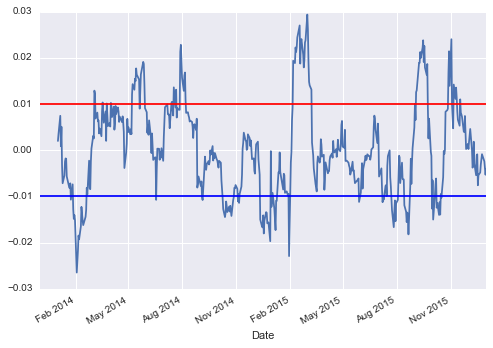

In [74]:
M = 10
g = 0.01
j = -0.01
fig = plt.figure()
spd_ret.plot()
plt.axhline(g,color='r')
plt.axhline(j,color='b')

print('M','g','j','profit')
for M in [5,10,21]:
    spd_ret = x_ret.rolling(window = M).sum()-y_ret.rolling(window = M).sum()
    for g in [0.005,0.01,0.15]:
        for j in [-0.005,-0.01,-0.15]:
            res = trade(spd_ret, M, g, j)
            profit = res["pos"]["profit"]
            print(M,g,j,sum(profit))